In [2]:
%run 'Import Dbase.ipynb'
%run 'Import Plots.ipynb'

In [3]:
# v1 heater 1 csv
# v4 heater 2 csv
# v5 line
# v8 fan csv

def tableName(run='004'):

    cursor = connectDbase('rct007')

    tbName0 = 'rct007_testID'
    tbName1 = run+'_flowindata'
    tbName2 = run+'_flowoutdata'
    tbName3 = run+'_plcdata'
    tbName4 = run+'_voltagedata'
    tbName5 = run+'_logdata'
    return [tbName0, tbName1, tbName2, tbName3, tbName4, tbName5]


def findPower(cvs, line):
    senseR = 2.
    voltD = 23.
    ph1 = (cvs/senseR) * (line*voltD)
    mph1 = np.mean(ph1)
    sph1 = np.std(ph1)
    return mph1, sph1

def findInputPower(volt):
    [mheater1,sheater1] = findPower(volt.v1, volt.v5)
    [mheater2,sheater2] = findPower(volt.v4, volt.v5)
    [mfan,sfan] = findPower(volt.v8, volt.v5)
    inputPower =  mheater1 + mheater2 + mfan
    return inputPower

def readVolt(start, end):
    a = '''
    SELECT *
    FROM %s ''' 

    b = '''
    WHERE date between \'%s\' AND \'%s\'
    '''%(start, end)
    rmsQuery = a+b
    volt = readTable(cursor, t4, rmsQuery)
    return volt

def parseLog(cursor, run):
    log = readNoDateTable(cursor, run+'_logdata')
    stateStart = log[log.state=='1'].date
    stateEnd = log[log.state=='0'].date
    return stateStart, stateEnd

def inputPowerVect(start, end):
    out = []
    for ii,s in enumerate(start):
        volt = readVolt(s,pd.to_datetime(end.values[ii]))
        out.append(findInputPower(volt))
    return out    

def rtdStats(rtd, amb, s, e):
    rtdMean = rtd.mean().mean()
    rtdStd = rtd.std().mean()
    boxMean = amb[['amb_rtd3','amb_rtd4']].mean().mean()
    ceilMean = amb[['amb_rtd1','amb_rtd2']].mean().mean()
    return rtdMean, rtdStd, boxMean, ceilMean

def rtdVect(cursor, t3, start, end):
    outM = []
    outS = []
    outB = []
    outC = []
    for ii,s in enumerate(start):
        
        plc = readDateTable(cursor, t3, s, pd.to_datetime(end.values[ii]))
        rct = plc[['rct_rtd1', 'rct_rtd2', 'rct_rtd3', 'rct_rtd4', 'rct_rtd5', 'rct_rtd6']]
        amb = plc[['amb_rtd1','amb_rtd2','amb_rtd3','amb_rtd4']]
  
        
        [rm, rs, bm, cm] = rtdStats(rct, amb, s,pd.to_datetime(end.values[ii]))
        outM.append(rm)
        outS.append(rs)
        outB.append(bm)
        outC.append(cm)
    return outM, outS, outB, outC

def flowStats(table, col, start, end):
    fi = readDateTable(cursor, table, start, end)
    pulseInDelta = fi.ix[-1,col] - fi.ix[0,col]
    dt = (fi.date[-1] - fi.date[0])
    #print fi.date[0], fi.date[-1]
    dts = dt.seconds
    fistd = np.std(np.diff(fi[col][1:-2]))
    return pulseInDelta, fistd, dts


def density(temp):
    Density = (1.626*(10**-5)*temp**3-6.021*(10**-3)*temp**2+0.021*temp + 1000.066)/1000
    return Density

def specificHeat(temp):
    SH = -3.588*(10**-11)*(temp**5)+1.212*(10**-8)*(temp**4)-1.564*(10**-6)*(temp**3)+1.036*(10**-4)*(temp**2)-3.266*(10**-3)*temp + 4.216
    return SH

def heatOutput(pulseOutDelta, pulseInDelta, flowInTemp, flowOutTemp, sampleTime):
    
    deltaT = flowOutTemp - flowInTemp
    Germanflowmetercalibration = 1860.

    #liter per min, there is error as OUT is greater than IN
    FLOWINVOLUME = pulseInDelta / Germanflowmetercalibration / sampleTime
    FLOWOUTVOLUME = pulseOutDelta / Germanflowmetercalibration / sampleTime
    #Mass flow rate - kg/sec
    Massflowin = FLOWINVOLUME * density(flowInTemp)
    Massflowout = FLOWOUTVOLUME * density(flowOutTemp)

    #Multiplying to get Q (mcdT) J/sec [W]
    Qin = (Massflowin * specificHeat(flowInTemp) * deltaT)*1000.
    Qout = (Massflowout * specificHeat(flowOutTemp) * deltaT)*1000.
    Qfinal = (Qin+Qout)/2.

    return Qfinal

def heatCalc(pulseDelta, flowTemp, deltaTemp, timeInteraval):
    
    germanFlowMeterCalibration = 1860.

    #liter per min, there is error as OUT is greater than IN
    volumeFlow = pulseDelta / germanFlowMeterCalibration / timeInteraval
    
    #Mass flow rate - kg/sec
    massFlow = volumeFlow * density(flowTemp)

    #Multiplying to get Q (mcdT) J/sec [W]
    Q = (massFlow * specificHeat(flowTemp) * deltaTemp)*1000.
    
    return Q


In [4]:
def flowVect(cursor, tin, tout, t3, start, end):
    fiPulse = []
    foPulse = []
    fiStd = []
    foStd = []
    qInV = []
    qOutV = []
    for ii,s in enumerate(start):
        plc = readDateTable(cursor, t3, s, pd.to_datetime(end.values[ii]))
        flow = plc[['flowin_rtd','flowout_rtd']]
        ftmean = flow.mean()
        deltaTemp = ftmean[1] - ftmean[0]
        
        [fip, fis, dtsi] = flowStats(tin, 'flowin', s, pd.to_datetime(end.values[ii]))
        [fop, fos, dtso] = flowStats(tout, 'flowout', s, pd.to_datetime(end.values[ii]))

        #heatOutOne = heatOutput(fop, fip, ftmean[0], ftmean[1], dtsi)
        Qin  = heatCalc(fip, ftmean[0], deltaTemp, dtsi)
        Qout = heatCalc(fop, ftmean[1], deltaTemp, dtso)
        Qfinal = (Qin+Qout)/2.
        print ii, Qin, Qout
        
        fiPulse.append(fip)
        fiStd.append(fis)
        foPulse.append(fop)
        foStd.append(fos)
        qInV.append(Qin)
        qOutV.append(Qout)
        
    return fiPulse, fiStd, foPulse, foStd, qInV, qOutV

In [5]:
s = start.copy()
e = end.copy()
s.reset_index()

NameError: name 'start' is not defined

In [87]:
flowOut = flowVect(cursor, t1, t2, t3, start, end)


0 27.0766923726 25.6685505691
1 45.9009443179 42.8273135583
2 66.8437408586 60.849060773
3 99.548512805 91.4494919628
4 171.869732665 159.627103059
5 239.258293598 221.836800614
6 25.7246306486 24.3540658234
7 26.3109057563 24.8347380114
8 44.6201790039 42.5938764283
9 63.8173618139 61.4995863567
10 100.550573696 98.7372242457
11 166.369444289 167.504980105
12 230.937759457 215.383276778
13 27.3702623482 25.733074269
14 27.2437473747 24.4405086115
15 43.8163097084 40.8094112442
16 62.8415308081 58.3811236895
17 98.9495362945 88.7982399168
18 165.840586874 155.203286018
19 233.802781759 217.537765775
20 26.5239276411 25.1589018134
21 25.7108092575 23.7733927369
22 44.1659587174 40.4750618787
23 63.3689336271 57.3290269834
24 99.2463915038 89.9859103443
25 165.241107002 150.448060862
26 237.003412281 212.952381838
27 27.3835369652 25.1915310073
28 25.9290729621 23.5353592774
29 44.8090909064 40.6352259393
30 63.2038582474 55.9107007114
31 99.9981766557 88.1496068756
32 172.132445393 149.

IndexError: index -1 is out of bounds for axis 0 with size 0

In [7]:
cursor = connectDbase('rct007')
[t0,t1,t2,t3,t4,t5] = tableName('004')
[start, end] = parseLog(cursor, '004')
numRuns = np.min([len(start), len(end)])
start = start[0:numRuns]
end = end[0:numRuns]

savePowIn =[]
numRuns = 4

start1 = start[len(savePowIn):numRuns]
end1 = end[len(savePowIn):numRuns]

#rtdOut = rtdVect(cursor, t3, start, end)

flowOut = flowVect(cursor, t1, t2, t3, start1, end1)

powerIn = inputPowerVect(start1,end1)
powerIn = savePowIn + powerIn

0 27.0766923726 25.6685505691
1 45.9009443179 42.8273135583
2 66.8437408586 60.849060773
3 99.548512805 91.4494919628


In [8]:
savePowIn = powerIn
powerOut = flowOut[-1]


In [9]:
powIn = flowOut[-2]
powOut = flowOut[-1]
pOutAvg = (np.array(powIn) + np.array(powOut)) / 2.

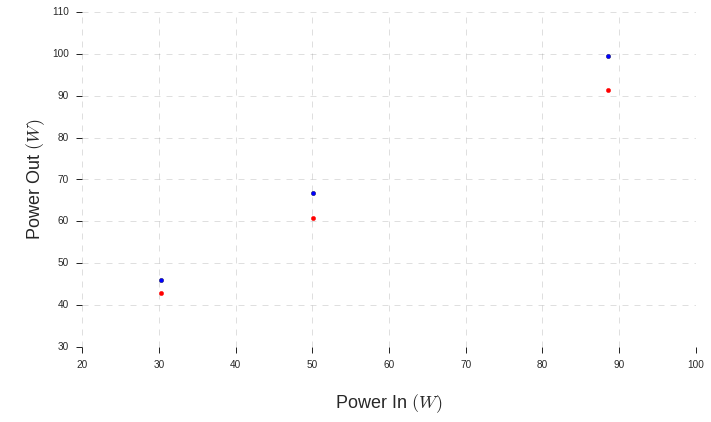

In [17]:
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(11, 6))
plt.scatter(powerIn, np.array(powOut),color='r')
plt.scatter(powerIn, np.array(powIn))
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)
plt.xlabel('\nPower In $(W)$', fontsize=18)
plt.ylabel('\nPower Out $(W)$', fontsize=18)


In [16]:
powerIn

[nan, 30.269903106829048, 50.10246526832036, 88.59499210652525]

In [12]:
powerOut

[25.66855056905813, 42.827313558287109, 60.849060773004524, 91.449491962802128]

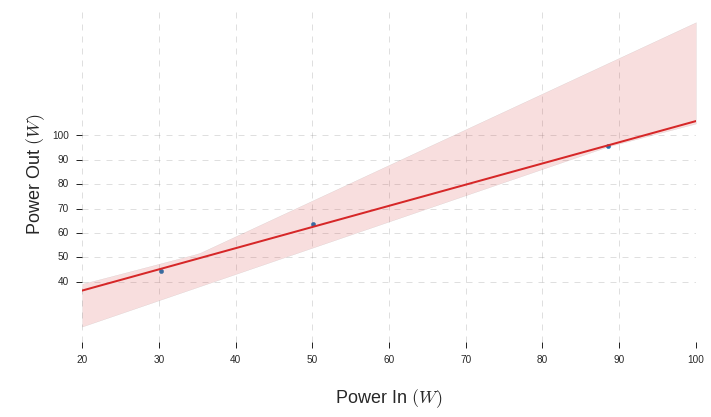

In [18]:
%matplotlib inline

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
    
    
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(powerIn, (pOutAvg), color=tableau20[0])
# fitIn = np.arange(0,300)
# ax.scatter(fitIn, slope*fitIn, color = tableau20[8])
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)
ax = sns.regplot(x=np.array(powerIn), y=np.array(pOutAvg), ci=99, line_kws={'lw': 2}, color=tableau20[6], scatter=False)
plt.xlabel('\nPower In $(W)$', fontsize=18)
plt.ylabel('\nPower Out $(W)$', fontsize=18)
# plt.xlabel('')
# plt.ylabel('')


In [1]:
powerIn

NameError: name 'powerIn' is not defined

In [73]:
len(powerIn)

70

In [23]:
vPI = [powerIn[i] for i in np.arange(0,13)]
vPO = [powOut[i] for i in np.arange(0,13)]
aPI = [powerIn[i] for i in np.arange(14,-1)]
aPO = [powOut[i] for i in np.arange(14,-1)]

vPI = np.array(vPI)
vPO = np.array(vPO)
aPI = np.array(aPI)
aPO = np.array(aPO)

In [24]:
vPI = (vPI + vPO) / 2.
aPI = (aPI + aPO) / 2.


(0, 300)

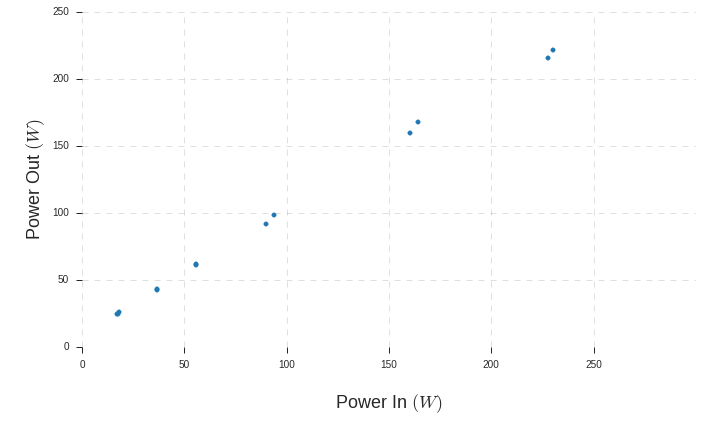

In [25]:

%matplotlib inline

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
    
    
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(vPI, vPO, color=tableau20[0])
ax.scatter(aPI, aPO, color=tableau20[2])
#ax = sns.regplot(x=np.array(powerIn), y=np.array(powOut), ci=99, line_kws={'lw': 2}, color=tableau20[6], scatter=False)
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)
plt.xlabel('\nPower In $(W)$', fontsize=18)
plt.ylabel('\nPower Out $(W)$', fontsize=18)
plt.xlim(0,300)
# plt.xlabel('')
# plt.ylabel('')


In [55]:
par = np.polyfit(powerIn, pOutAvg, 1, full=True)
slope = par[0][0]
intercept = par[0][1]
print 'slope = %f\tintercept = %f\n'%(slope, intercept)

slope = 0.872004	intercept = 15.929056



In [27]:
import statsmodels.api as sm
linearFitModel = sm.OLS(powerOut, powerIn).fit()
linearFitModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     4283.
Date:                Mon, 04 Jul 2016   Prob (F-statistic):           7.34e-54
Time:                        13:20:48   Log-Likelihood:                -219.66
No. Observations:                  56   AIC:                             441.3
Df Residuals:                      55   BIC:                             443.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.9264      0.014     65.448      0.000         0.898     0.955
==============================================================================
Omnibus:                       22.189   Durbin-Watson:                   0.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.234
Skew:                          -1.531   Prob(JB):                     2.72e-07
Kurtosis:                       4.893   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
10e-11

1e-10